# Diagnostics & Visualizations

Recall embedding-based metrics rely on an embedding model. How do we choose a "good" embedding model for the biological sequences of our interest - so we can later evaluate these sequences with the embedding-based metrics? We will answer this question in this notebook. We will also show how to visualize embeddings using seqme.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import seqme as sm

## Embedding models


Let's start by loading some sequences.


In [ ]:
DATASET_PATHS = {
    "UniProt": "./data/dbs/uniprot/uniprot_8_50_100.fasta",
    "AMP-data": "./data/dbs/amps.fasta",
}

In [ ]:
datasets = {name: sm.read_fasta(path) for name, path in DATASET_PATHS.items()}

In [ ]:
for model_name, sequences in datasets.items():
    print(f"{model_name}: {len(sequences)} sequences")

UniProt: 2933310 sequences
AMP-data: 38473 sequences


In [ ]:
n_samples = 500
seed = 42

data = {
    name: sm.sample_subset(sequences, n_samples=n_samples, seed=seed) if len(sequences) > n_samples else sequences
    for name, sequences in datasets.items()
}

Let's setup the cache.

In [ ]:
models = {
    "charge": sm.models.Charge(),
    "esm2": sm.models.ESM2(
        model_name=sm.models.ESM2Checkpoint.t6_8M,
        batch_size=256,
        device="cpu",
        verbose=True,
    ),
    "hyformer": sm.models.Hyformer(
        model_name=sm.models.HyformerCheckpoint.peptides_34M,
        batch_size=256,
        device="cpu",
        verbose=True,
    ),
    # "prostT5": sm.models.ProstT5(
    #    batch_size=32,
    #    device="cpu",
    #    verbose=True,
    # ),
}

cache = sm.Cache(models)

Model weights loaded from SzczurekLab/hyformer_peptides_34M
Model state_dict loaded with `strict=False`. Missing keys: [], Unexpected keys: ['prediction_head.dense.weight', 'prediction_head.dense.bias', 'prediction_head.out_proj.weight', 'prediction_head.out_proj.bias']


/home/adamizdebski/tools/apps/mamba/lib/python3.10/site-packages/hyformer/models/utils/state_dict_utils.py:29: UserWarning: Model is not compiled but state dict is. Removing prefix from state dict.
  warnings.warn("Model is not compiled but state dict is. Removing prefix from state dict.")


### Diagnostics


We are interested in selecting an embedding model which orders the embedding space by "AMP"-likeness, i.e., the degree in which a peptides "looks" like a peptide with antimicrobial properties.


In [ ]:
positives = data["AMP-data"]
negatives = data["UniProt"]

labels = np.array([0] * len(negatives) + [1] * len(positives))
sequences = negatives + positives

In [ ]:
cache.add("esm2-4d", sm.models.PCA(cache.model("esm2"), sequences, n_components=4))
cache.add("hyformer-4d", sm.models.PCA(cache.model("hyformer"), sequences, n_components=4))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.80s/it]


#### Feature alignment score


To evaluate "AMP-likeness", we can use the feature alignment score which is a measure for how homogenous neighborhoods are in the embedding space. We prefer AMPs cluster together. Thus, we compute the feature alignment score for different neighborhood sizes. A score of 1.0 means the sequences are clustered by "AMP-likeness". A score of 0.0 means the embedding space is not able to group by our feature of interest.


In [ ]:
n_neighbours = [1, 2, 4, 8, 16, 32, 64, 128]

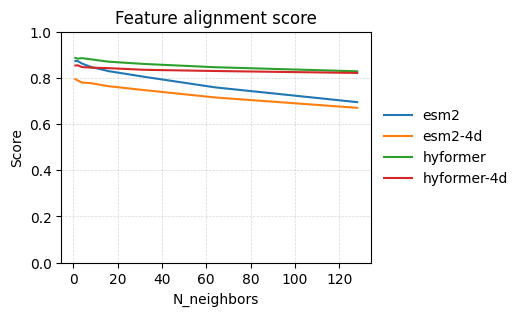

In [ ]:
embedding_models = ["esm2", "esm2-4d", "hyformer", "hyformer-4d"]

fig, ax = plt.subplots(figsize=(4, 3))
for model_name in embedding_models:
    xs = cache.model(model_name)(sequences)
    sm.utils.plot_feature_alignment_score(xs, labels, n_neighbours, label=model_name, ax=ax)

The sequences produced by hyformer is better at seperating AMPs from non-AMPs than the other.

#### Spearman correlation coefficient


The spearman correlation coefficient computes how well an embedding space aligns with a reference embedding space. We know AMPs are usually positively charged, so let's see how well the embedding model aligns with this feature.


In [ ]:
xs_embedder_esm2 = cache.model("esm2")(sequences)
xs_charge = cache.model("charge")(sequences)

score = sm.utils.spearman_correlation(xs_embedder_esm2, xs_charge[:, None])

print(f"Spearman correlation coefficient: {score:.2f}")

Spearman correlation coefficient: 0.19


In [ ]:
xs_embedder_hyformer = cache.model("hyformer")(sequences)
xs_charge = cache.model("charge")(sequences)

score = sm.utils.spearman_correlation(xs_embedder_hyformer, xs_charge[:, None])

print(f"Spearman correlation coefficient: {score:.2f}")

Spearman correlation coefficient: 0.10


### Visualization


Let's now visualize the embedding spaces.


First let's extract the sequences to visualize.


In [ ]:
colors = ["red", "green"]

embedder_name_esm2 = "esm2"
embedder_name_hyformer = "hyformer"

embedder_esm2 = cache.model(embedder_name_esm2)
embedder_hyformer = cache.model(embedder_name_hyformer)

In [ ]:
embeddings_esm2 = {name: embedder_esm2(sequences) for name, sequences in data.items()}
embeddings_hyformer = {name: embedder_hyformer(sequences) for name, sequences in data.items()}

embedding_names_esm2 = list(embeddings_esm2.keys())
embedding_names_hyformer = list(embeddings_hyformer.keys())

embedding_values_esm2 = list(embeddings_esm2.values())
embedding_values_hyformer = list(embeddings_hyformer.values())

#### PCA


Let's do a PCA plot.


In [ ]:
xs_pca_esm2 = sm.utils.pca(embedding_values_esm2)
xs_pca_esm2 = dict(zip(embedding_names_esm2, xs_pca_esm2, strict=True))

xs_pca_hyformer = sm.utils.pca(embedding_values_hyformer)
xs_pca_hyformer = dict(zip(embedding_names_hyformer, xs_pca_hyformer, strict=True))

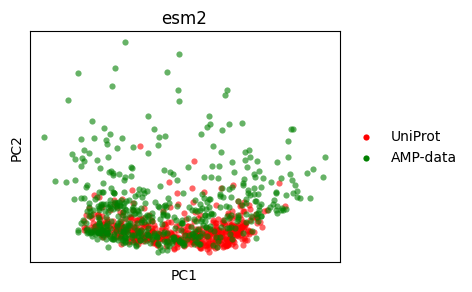

In [ ]:
sm.utils.plot_embeddings(
    xs_pca_esm2.values(),
    values=xs_pca_esm2.keys(),
    colors=colors,
    title=embedder_name_esm2,
    xlabel="PC1",
    ylabel="PC2",
)

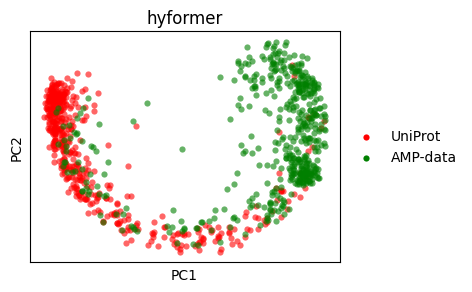

In [ ]:
sm.utils.plot_embeddings(
    xs_pca_hyformer.values(),
    values=xs_pca_hyformer.keys(),
    colors=colors,
    title=embedder_name_hyformer,
    xlabel="PC1",
    ylabel="PC2",
)

#### t-SNE


Let's do a t-SNE plot.


In [ ]:
xs_tsne_esm2 = sm.utils.tsne(embedding_values_esm2)
xs_tsne_esm2 = dict(zip(embedding_names_esm2, xs_tsne_esm2, strict=True))

xs_tsne_hyformer = sm.utils.tsne(embedding_values_hyformer)
xs_tsne_hyformer = dict(zip(embedding_names_hyformer, xs_tsne_hyformer, strict=True))

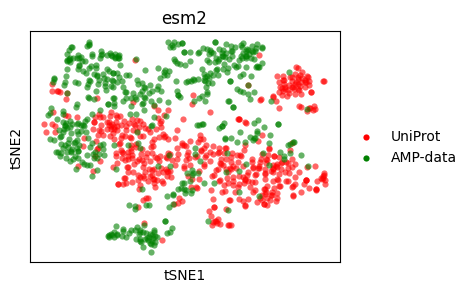

In [ ]:
sm.utils.plot_embeddings(
    xs_tsne_esm2.values(),
    values=xs_tsne_esm2.keys(),
    colors=colors,
    title=embedder_name_esm2,
    xlabel="tSNE1",
    ylabel="tSNE2",
)

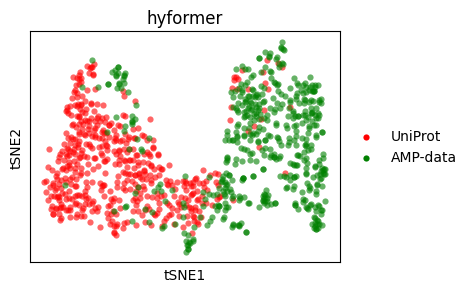

In [ ]:
sm.utils.plot_embeddings(
    xs_tsne_hyformer.values(),
    values=xs_tsne_hyformer.keys(),
    colors=colors,
    title=embedder_name_hyformer,
    xlabel="tSNE1",
    ylabel="tSNE2",
)

#### UMAP


Let's do a UMAP plot.


In [ ]:
xs_umap_esm2 = sm.utils.umap(embedding_values_esm2)
xs_umap_esm2 = dict(zip(embedding_names_esm2, xs_umap_esm2, strict=True))

xs_umap_hyformer = sm.utils.umap(embedding_values_hyformer)
xs_umap_hyformer = dict(zip(embedding_names_hyformer, xs_umap_hyformer, strict=True))

/home/adamizdebski/tools/apps/mamba/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/adamizdebski/tools/apps/mamba/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


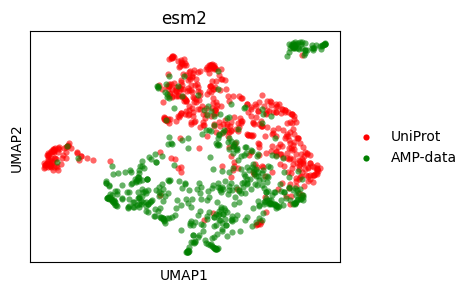

In [ ]:
sm.utils.plot_embeddings(
    xs_umap_esm2.values(),
    values=xs_umap_esm2.keys(),
    title=embedder_name_esm2,
    colors=colors,
    xlabel="UMAP1",
    ylabel="UMAP2",
)

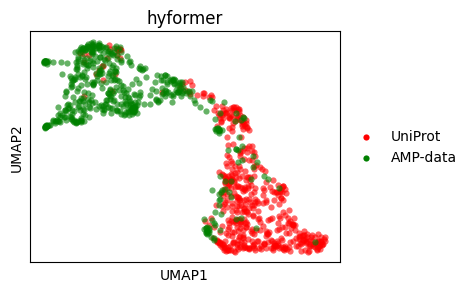

In [ ]:
sm.utils.plot_embeddings(
    xs_umap_hyformer.values(),
    values=xs_umap_hyformer.keys(),
    title=embedder_name_hyformer,
    colors=colors,
    xlabel="UMAP1",
    ylabel="UMAP2",
)

#### Embedding + Property


Let's do an UMAP for a single list of sequences and color those sequences based on a property.


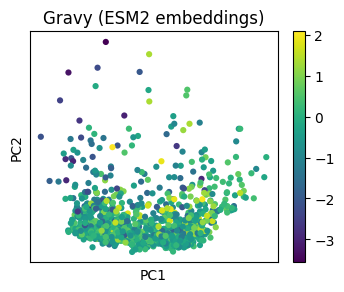

In [ ]:
property_model = sm.models.Gravy()

sm.utils.plot_embeddings(
    xs_pca_esm2.values(),
    values=[property_model(data[name]) for name in xs_pca_esm2.keys()],
    title="Gravy (ESM2 embeddings)",
    alpha=1.0,
    cmap="viridis",
    xlabel="PC1",
    ylabel="PC2",
)

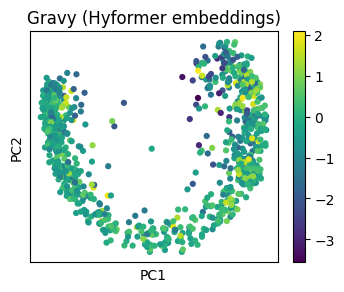

In [ ]:
property_model = sm.models.Gravy()

sm.utils.plot_embeddings(
    xs_pca_hyformer.values(),
    values=[property_model(data[name]) for name in xs_pca_hyformer.keys()],
    title="Gravy (Hyformer embeddings)",
    alpha=1.0,
    cmap="viridis",
    xlabel="PC1",
    ylabel="PC2",
)

## Property models


Let's create a violin plot for one property.

In [ ]:
cache = sm.Cache(models={"Gravy": sm.models.Gravy(), "Molecular Weight": sm.models.ProteinWeight()})

In [ ]:
properties = {name: cache.model("Gravy")(sequences) for name, sequences in data.items()}

<Axes: ylabel='Gravy'>

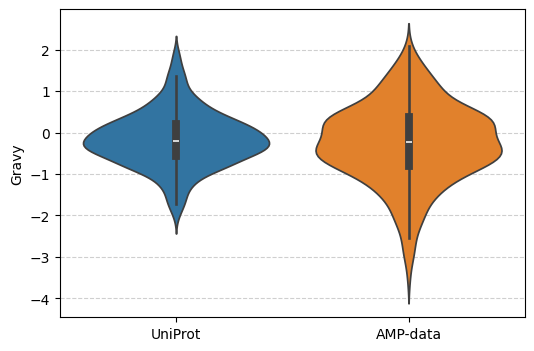

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.grid(axis="y", linestyle="--", alpha=0.6)
ax.set_axisbelow(True)
ax.set_ylabel("Gravy")
sns.violinplot(properties, bw_method="scott", ax=ax)